In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Save parameters

In [2]:
def save_torch_to_csv(torch_data,filename):
    pd.DataFrame(torch_data.detach().numpy()).to_csv(filename)

### Set random seeds

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    print(f"seed: {seed}")
    
seed_everything(42)

seed: 42


# 1. The Elman Network Class
### [torch.nn.RNNCell](https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html)

In [4]:
class ElmanRNN(nn.Module):
    """ an Elman RNN built using the RNNCell """
    def __init__(self, input_size, hidden_size, batch_first=False, verbose=False):
        """
        Args:
            input_size (int): size of the input vectors
            hidden_size (int): size of the hidden state vectors
            bathc_first (bool): whether the 0th dimension is batch
        """
        super(ElmanRNN, self).__init__()
        
        seed_everything(42)
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        
        self.batch_first = batch_first
        self.hidden_size = hidden_size
        self.verbose     = verbose

    def _initial_hidden(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size))

    def forward(self, x_in, initial_hidden=None):
        """The forward pass of the ElmanRNN
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                If self.batch_first: x_in.shape = (batch, seq_size, feat_size)
                Else: x_in.shape = (seq_size, batch, feat_size)
            initial_hidden (torch.Tensor): the initial hidden state for the RNN
        Returns:
            hiddens (torch.Tensor): The outputs of the RNN at each time step. 
                If self.batch_first: hiddens.shape = (batch, seq_size, hidden_size)
                Else: hiddens.shape = (seq_size, batch, hidden_size)
        """
        
        if self.verbose:
            print("x_in, shape:", x_in.shape)
            print(x_in)
            print("-"*60)

        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
            if self.verbose:
                print("batch_first = True, so x_in is permuted")
                print("permuted x_in, shape,", x_in.shape)
                print(x_in)
                print("-"*60)
        else:
            seq_size, batch_size, feat_size = x_in.size()
        
        
        hiddens = []

        if initial_hidden is None:
            initial_hidden = self._initial_hidden(batch_size)
            initial_hidden = initial_hidden.to(x_in.device)
        if self.verbose:
            print(f"initial hidden, shape:", initial_hidden.shape)
            print(initial_hidden)
            print("-"*60)

        hidden_t = initial_hidden
                    
        for t in range(seq_size):

            hidden_t = self.rnn_cell(x_in[t], hidden_t)
            
            if self.verbose:
                print(f"hidden at time step {t}, shape: {hidden_t.shape}")
                print(hidden_t)
                print("-"*60)

            
            hiddens.append(hidden_t)
            
        hiddens = torch.stack(hiddens)
        if self.verbose:
            print("Stacked hiddens (before permute), shape:", {hiddens.shape})
            print(hiddens)
            print("-"*60)
        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)
        if self.verbose:
            print("Stacked hiddens (after permute), shape:", {hiddens.shape})
            print(hiddens)
        return hiddens

# 2. The Embedding layer

### The x input

In [5]:
seed_everything(42)
batch_size     = 2
length_of_text = 7
my_input = torch.randint(0,20,[batch_size, length_of_text])
my_input

seed: 42


tensor([[ 2,  7, 16, 14,  6, 15,  0],
        [ 4, 10, 13, 18, 14, 10, 14]])

### The nn.Embedding layer
#### More details [Embedding](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Frankenstein/Embedding_layer.ipynb), [Embedding+CNN](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/AGNews/NewsClassifier.ipynb)

In [6]:
# the number of embeddings (the number of vocabulary items)
n_tokens_in_vocabulary = 20
# size of the embeddings (embedding dimension)
dimension_embedding    = 4
# If one specifies padding_idx=0 every input where the value is equal to padding_idx will 
# be zero-ed out 
padding_idx            = 0

In [7]:
seed_everything(42)
my_emb = nn.Embedding(num_embeddings = n_tokens_in_vocabulary, 
                      embedding_dim  = dimension_embedding,
                      padding_idx    = padding_idx)  

seed: 42


In [8]:
### The output of the nn.Embedding layer (i.e.,the input of the RNNCell layer)
x_in = my_emb(my_input)

In [9]:
print("For the nn.Embedding Layer")
print("Shape of input: ", my_input.shape)
print("Shape of output: ", x_in.shape)
print(x_in.shape)
print("-"*60)
print("x_in, the input to the next step")
print(x_in)

For the nn.Embedding Layer
Shape of input:  torch.Size([2, 7])
Shape of output:  torch.Size([2, 7, 4])
torch.Size([2, 7, 4])
------------------------------------------------------------
x_in, the input to the next step
tensor([[[-0.7521,  1.6487, -0.3925, -1.4036],
         [-0.2316,  0.0418, -0.2516,  0.8599],
         [ 1.4451,  0.8564,  2.2181,  0.5232],
         [-1.4032,  0.0360, -0.0635,  0.6756],
         [ 1.2791,  1.2964,  0.6105,  1.3347],
         [-0.0978,  1.8446, -1.1845,  1.3835],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 1.6423, -0.1596, -0.4974,  0.4396],
         [-1.5576,  0.9956, -0.8798, -0.6011],
         [-0.4880,  1.1914, -0.8140, -0.7360],
         [-0.1722,  0.5238,  0.0566,  0.4263],
         [-1.4032,  0.0360, -0.0635,  0.6756],
         [-1.5576,  0.9956, -0.8798, -0.6011],
         [-1.4032,  0.0360, -0.0635,  0.6756]]], grad_fn=<EmbeddingBackward0>)


# 3.  The RNNCell layer
### AS shown above, the output of the emdedding layer is a tensor with dimension = [2,7,4]. 
### In this context, the three dimensions could be 
- batch_first = True: [batch_size, sequence_size, feature_size]
- batch_first = False: [sequence_size, batch_size, feature_size]

###  The meaning of the three sizes are below:
#### - sequence_size: The length of the sequence, representing the number of time steps in the input sequence. In NLP, this typically corresponds to the number of words (or other basic units) in the input sentence or document. Each time step usually represents one word (or word vector). In this case, sequence_size = 7, meaning that there are seven words in each sentence input, or there are seven characters in each word input. 
#### - batch_size: The size of the batch, indicating the number of samples processed simultaneously during a single training or inference process. A larger batch size can utilize parallel computation to improve efficiency. In NLP, batch size often corresponds to processing multiple sentences or documents in a single input. In this case, batch_size = 2, meaning that there are 2 sentence inputs, or 2 word inputs. 
#### feature_size: The input dimension, representing the number of input features at each time step. In NLP, this typically corresponds to the dimensionality of word embeddings. For example, if each word is represented using 300-dimensional word vectors, then the input_size would be 300. In this case, feature_size = 4, meaning that the embedding dimension is 4, and each word in a sentence of each character in a word is represented by a vector of legnth 4. 

In [10]:
print("Shape of x_in(output of the embedding layer):", x_in.size())
batch_size, seq_size, feat_size = x_in.size()
print("batch_size:", batch_size)
print("seq_size:", seq_size)
print("feat_size:", feat_size)

Shape of x_in(output of the embedding layer): torch.Size([2, 7, 4])
batch_size: 2
seq_size: 7
feat_size: 4


### Since batch_first = True, i.e, 0th dimension of x_in is batch_size, x_in will be permuted. 

In [11]:
print("x_in before permute")
print("Shape:", x_in.shape)
print(x_in)
print("-"*80)
print("x_in after permute")
x_in = x_in.permute(1, 0, 2)
print("Shape:", x_in.shape)
print(x_in)

x_in before permute
Shape: torch.Size([2, 7, 4])
tensor([[[-0.7521,  1.6487, -0.3925, -1.4036],
         [-0.2316,  0.0418, -0.2516,  0.8599],
         [ 1.4451,  0.8564,  2.2181,  0.5232],
         [-1.4032,  0.0360, -0.0635,  0.6756],
         [ 1.2791,  1.2964,  0.6105,  1.3347],
         [-0.0978,  1.8446, -1.1845,  1.3835],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 1.6423, -0.1596, -0.4974,  0.4396],
         [-1.5576,  0.9956, -0.8798, -0.6011],
         [-0.4880,  1.1914, -0.8140, -0.7360],
         [-0.1722,  0.5238,  0.0566,  0.4263],
         [-1.4032,  0.0360, -0.0635,  0.6756],
         [-1.5576,  0.9956, -0.8798, -0.6011],
         [-1.4032,  0.0360, -0.0635,  0.6756]]], grad_fn=<EmbeddingBackward0>)
--------------------------------------------------------------------------------
x_in after permute
Shape: torch.Size([7, 2, 4])
tensor([[[-0.7521,  1.6487, -0.3925, -1.4036],
         [ 1.6423, -0.1596, -0.4974,  0.4396]],

        [[-0.2316,  0.0418, -0.251

### Permutation of the input data
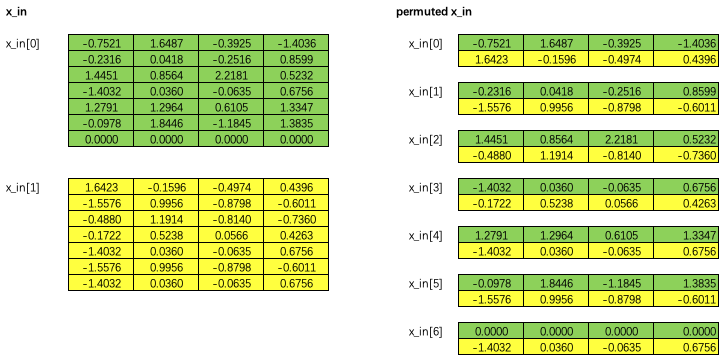

In [12]:
### Defined the RNNCell layer (extracted from ElmanRNN)
seed_everything(42)
hidden_size = 3
my_rnn  = nn.RNNCell(dimension_embedding, hidden_size)

seed: 42


In [13]:
### Print the parameters in my_rnn
for i in my_rnn.named_parameters():
    print(i[0])
    print(i[1])
    print(f"Shape:{i[1].shape}")
    print("-"*80)

weight_ih
Parameter containing:
tensor([[ 0.4414,  0.4792, -0.1353,  0.5304],
        [-0.1265,  0.1165, -0.2811,  0.3391],
        [ 0.5090, -0.4236,  0.5018,  0.1081]], requires_grad=True)
Shape:torch.Size([3, 4])
--------------------------------------------------------------------------------
weight_hh
Parameter containing:
tensor([[ 0.4266,  0.0782,  0.2784],
        [-0.0815,  0.4451,  0.0853],
        [-0.2695,  0.1472, -0.2660]], requires_grad=True)
Shape:torch.Size([3, 3])
--------------------------------------------------------------------------------
bias_ih
Parameter containing:
tensor([-0.0677, -0.2345,  0.3830], requires_grad=True)
Shape:torch.Size([3])
--------------------------------------------------------------------------------
bias_hh
Parameter containing:
tensor([-0.4557, -0.2662, -0.1630], requires_grad=True)
Shape:torch.Size([3])
--------------------------------------------------------------------------------


In [14]:
initial_hidden = torch.zeros((batch_size, hidden_size))
initial_hidden

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [15]:
output = []
hidden_t = initial_hidden
for i in range(seq_size):
    hidden_t = my_rnn(x_in[i],hidden_t)
    output.append(hidden_t)
output

[tensor([[-0.6391, -0.5220, -0.8366],
         [ 0.4015, -0.4121,  0.7265]], grad_fn=<TanhBackward0>),
 tensor([[-0.5797, -0.3415,  0.3532],
         [-0.5316, -0.2898, -0.9530]], grad_fn=<TanhBackward0>),
 tensor([[ 0.3155, -0.8021,  0.9441],
         [-0.7456, -0.4525, -0.5829]], grad_fn=<TanhBackward0>),
 tensor([[-0.4003, -0.3576, -0.7271],
         [-0.5688, -0.4459,  0.2677]], grad_fn=<TanhBackward0>),
 tensor([[ 0.7097, -0.3961,  0.7703],
         [-0.7450, -0.1986, -0.4234]], grad_fn=<TanhBackward0>),
 tensor([[ 0.9351,  0.3455, -0.9070],
         [-0.8820, -0.2050, -0.8387]], grad_fn=<TanhBackward0>),
 tensor([[-0.3364, -0.4625,  0.2543],
         [-0.8819, -0.1615, -0.0376]], grad_fn=<TanhBackward0>)]

### Calculation of the hidden at one time step, using the information from current input (x_in[t]) and previous hidden state (h[t-1]). 
### 1. The i-th item in x_in matmul with the j-th item in weight_ih, add the j-th item in bias_ih, results in the i-th row and j-th column in the matrix in the blue rectangle 
### 2. The i-th item in the previous hidden matrix, h(t-1), matmul with the j-th item in weight_hh, add the j-th item in bias_hh, results in the i-th row and j-th column in the matrix in the green rectangle 
### 3. The output in the previous 2 steps are two matrix with the same shape. The sum of these matrices are the hidden matrix at time step t. 
### 4. A tanh transformation is conducted at the last step to ensure that the hidden state values remain within a bounded range, specifically between -1 and 1. 
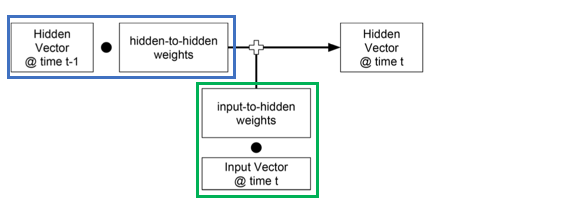

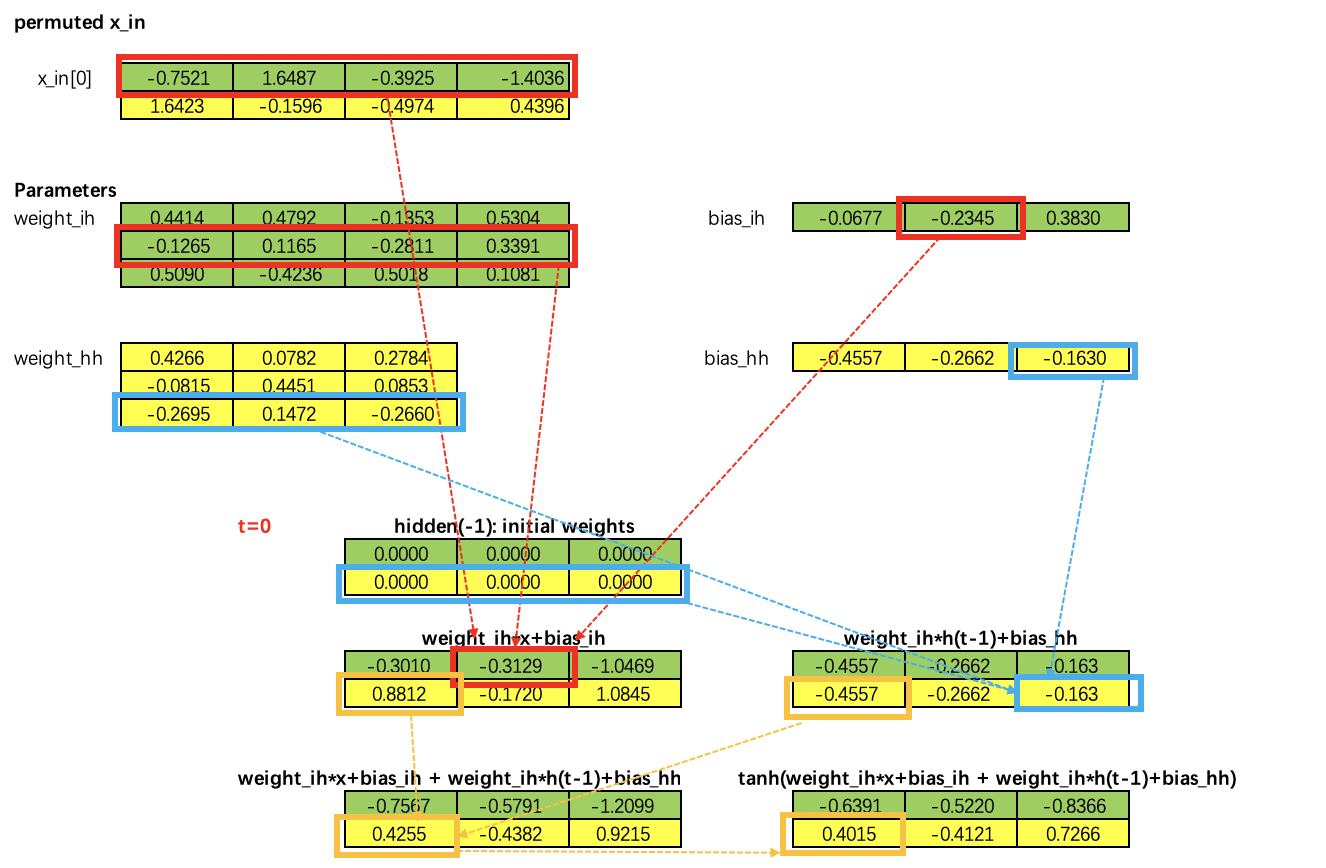

### RNNs process sequential data in a recursive manner by passing the hidden state from one time step to the next, allowing information to persist across the sequence.
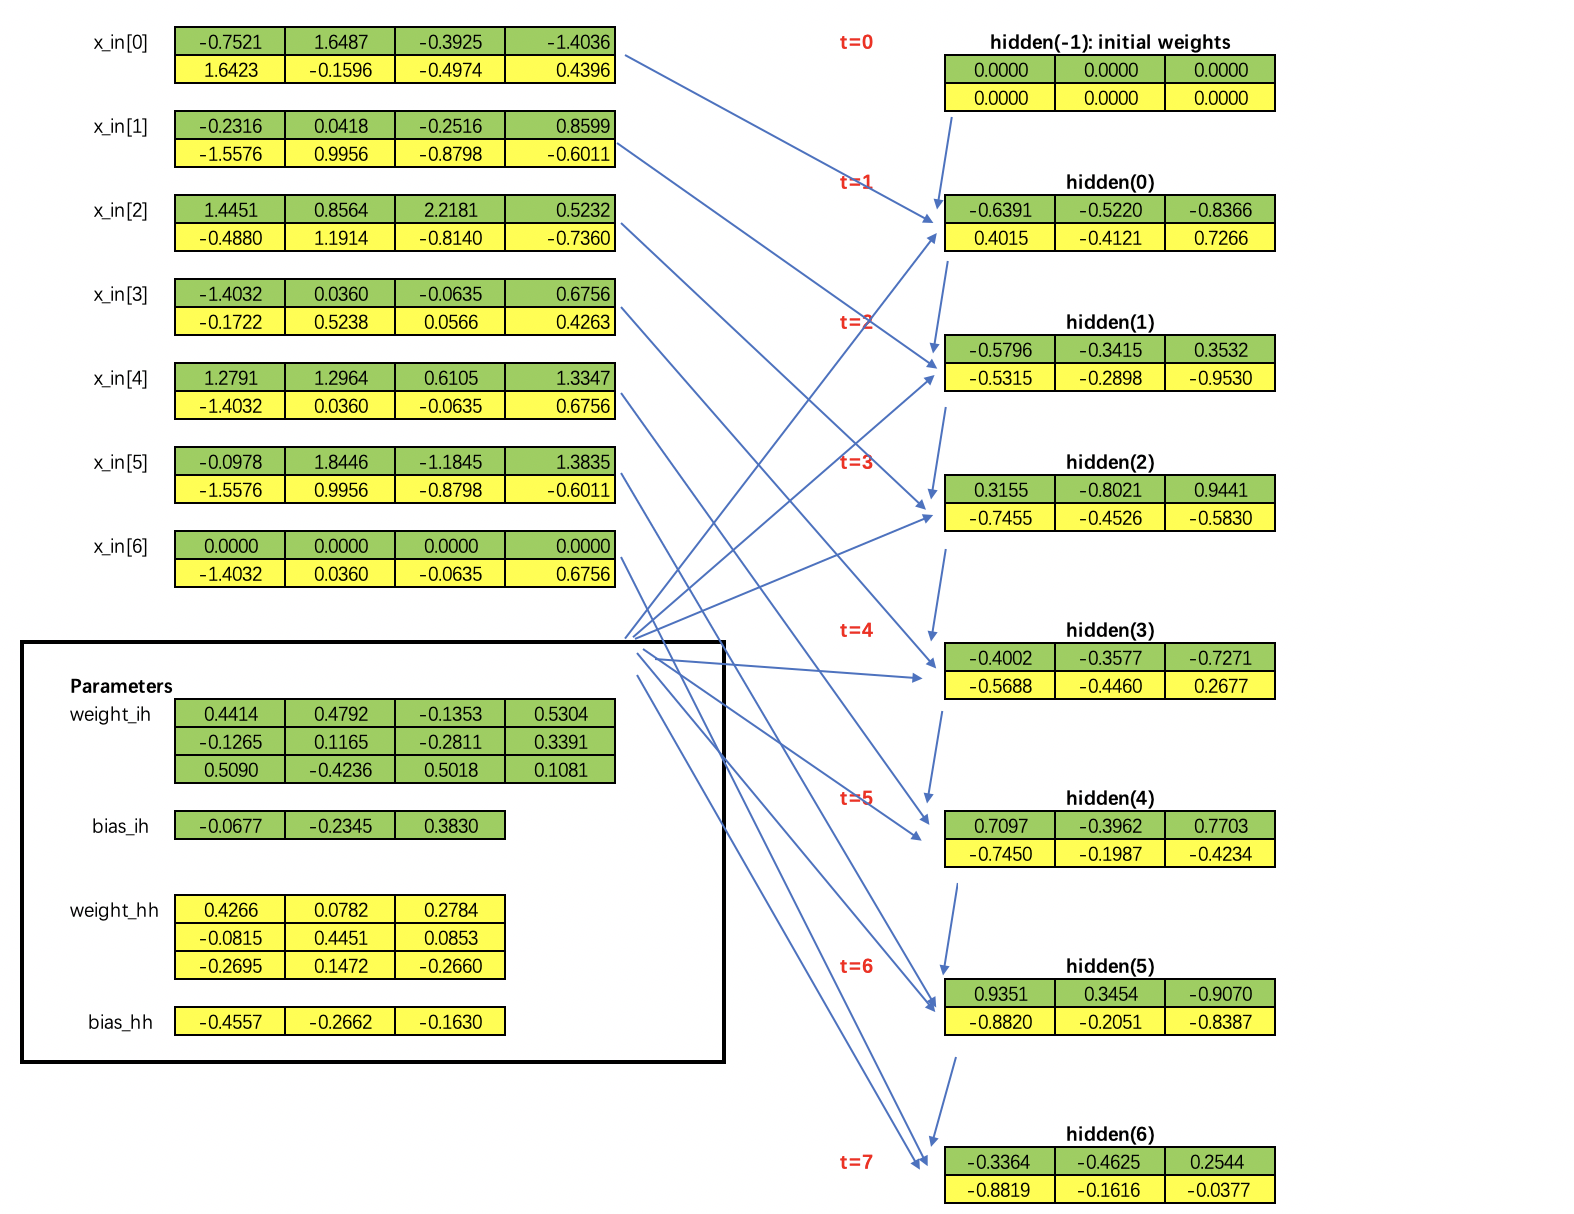

In [16]:
### Stack the output
print("Shape before stacking:", len(output))
print("Shape after stacking:", torch.stack(output).shape)

Shape before stacking: 7
Shape after stacking: torch.Size([7, 2, 3])


In [17]:
### Permute the stacked output
hiddens =  torch.stack(output).permute(1, 0, 2)
print("Shape after permutation", hiddens.shape)
hiddens

Shape after permutation torch.Size([2, 7, 3])


tensor([[[-0.6391, -0.5220, -0.8366],
         [-0.5797, -0.3415,  0.3532],
         [ 0.3155, -0.8021,  0.9441],
         [-0.4003, -0.3576, -0.7271],
         [ 0.7097, -0.3961,  0.7703],
         [ 0.9351,  0.3455, -0.9070],
         [-0.3364, -0.4625,  0.2543]],

        [[ 0.4015, -0.4121,  0.7265],
         [-0.5316, -0.2898, -0.9530],
         [-0.7456, -0.4525, -0.5829],
         [-0.5688, -0.4459,  0.2677],
         [-0.7450, -0.1986, -0.4234],
         [-0.8820, -0.2050, -0.8387],
         [-0.8819, -0.1615, -0.0376]]], grad_fn=<PermuteBackward0>)

### The same results can be achieved using ElmanRNN

In [18]:
my_ElmanRNN = ElmanRNN(input_size  = dimension_embedding,
                       hidden_size = 3,
                       batch_first = True,
                       verbose     = True)
x_in   = my_emb(my_input)
output = my_ElmanRNN(x_in)

seed: 42
x_in, shape: torch.Size([2, 7, 4])
tensor([[[-0.7521,  1.6487, -0.3925, -1.4036],
         [-0.2316,  0.0418, -0.2516,  0.8599],
         [ 1.4451,  0.8564,  2.2181,  0.5232],
         [-1.4032,  0.0360, -0.0635,  0.6756],
         [ 1.2791,  1.2964,  0.6105,  1.3347],
         [-0.0978,  1.8446, -1.1845,  1.3835],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 1.6423, -0.1596, -0.4974,  0.4396],
         [-1.5576,  0.9956, -0.8798, -0.6011],
         [-0.4880,  1.1914, -0.8140, -0.7360],
         [-0.1722,  0.5238,  0.0566,  0.4263],
         [-1.4032,  0.0360, -0.0635,  0.6756],
         [-1.5576,  0.9956, -0.8798, -0.6011],
         [-1.4032,  0.0360, -0.0635,  0.6756]]], grad_fn=<EmbeddingBackward0>)
------------------------------------------------------------
batch_first = True, so x_in is permuted
permuted x_in, shape, torch.Size([7, 2, 4])
tensor([[[-0.7521,  1.6487, -0.3925, -1.4036],
         [ 1.6423, -0.1596, -0.4974,  0.4396]],

        [[-0.2316,  0.0

# 4. column_gather
### The output of the ElmanRNN class is a three dimensional tensor—there is a hidden state vector for each data point on the batch dimension and each time step. 

### These vectors represent the hidden state for each character in the surname. Because the goal is to classify each surname, the vector corresponding to the final character position in each surname is extracted. One way to think about this vector is that the final vector is a result of passing over the entire sequence input, and hence it’s a summary vector for the surname. 

### Extracting the hidden state at the last valid time step of each sequence as the output is very common in many natural language processing (NLP) tasks and other sequence processing tasks because the hidden state at the last valid time step is typically considered to encapsulate the entire sequence's information. This is usually what to pass downstream for sequence prediction tasks.

### These summary vectors are passed through the Linear layer to compute a prediction vector. 

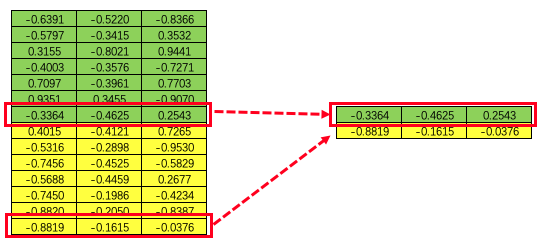

In [19]:
my_ElmanRNN = ElmanRNN(input_size  = dimension_embedding,
                       hidden_size = 3,
                       batch_first = True,
                       verbose     = False)
x_in = my_emb(my_input)
y_out = my_ElmanRNN(x_in)
y_out

seed: 42


tensor([[[-0.6391, -0.5220, -0.8366],
         [-0.5797, -0.3415,  0.3532],
         [ 0.3155, -0.8021,  0.9441],
         [-0.4003, -0.3576, -0.7271],
         [ 0.7097, -0.3961,  0.7703],
         [ 0.9351,  0.3455, -0.9070],
         [-0.3364, -0.4625,  0.2543]],

        [[ 0.4015, -0.4121,  0.7265],
         [-0.5316, -0.2898, -0.9530],
         [-0.7456, -0.4525, -0.5829],
         [-0.5688, -0.4459,  0.2677],
         [-0.7450, -0.1986, -0.4234],
         [-0.8820, -0.2050, -0.8387],
         [-0.8819, -0.1615, -0.0376]]], grad_fn=<PermuteBackward0>)

### When all the text inputs (i.e., surnames) in a batch have the same lengths, one can directly use the indexing approach to select the last element in the sequence_length dimension.

In [20]:
my_ElmanRNN = ElmanRNN(input_size  = dimension_embedding,
                       hidden_size = 3,
                       batch_first = True,
                       verbose     = False)
x_in  = my_emb(my_input)
y_out = my_ElmanRNN(x_in)
y_out = y_out[:, -1, :]
y_out

seed: 42


tensor([[-0.3364, -0.4625,  0.2543],
        [-0.8819, -0.1615, -0.0376]], grad_fn=<SliceBackward0>)

### When the different text inputs (i.e., surnames) in a batch have varying lengths, the following code can be used to select the last element of each sequence (numbered by length_of_text - 1):

In [21]:
my_ElmanRNN = ElmanRNN(input_size  = dimension_embedding,
                       hidden_size = 3,
                       batch_first = True,
                       verbose     = False)
x_in = my_emb(my_input)
y_out = my_ElmanRNN(x_in)
y_out

x_lengths = tensor = torch.LongTensor([length_of_text, length_of_text])-1
out = []
for batch_index, column_index in enumerate(x_lengths):
    out.append(y_out[batch_index, column_index])
### Concatenates a sequence of tensors along a new dimension. 
### dim: dimension to insert. Default: 0
y_out = torch.stack(out, dim=0)
y_out

seed: 42


tensor([[-0.3364, -0.4625,  0.2543],
        [-0.8819, -0.1615, -0.0376]], grad_fn=<StackBackward0>)

# 5. The Linear layers

In [22]:
### Defined the two Linear layers
seed_everything(42)
fc1 = nn.Linear(in_features=hidden_size, out_features=hidden_size)
seed_everything(42)
fc2 = nn.Linear(in_features=hidden_size, out_features=6)

seed: 42
seed: 42


In [23]:
print("Input(output of the RNN layer)")
print(y_out)
print("Shape:", y_out.shape)
print("-"*80)


print("Output of fc1")
print(fc1(y_out))
print("Shape:", fc1(y_out).shape)
print("-"*80)

print("Output of fc2")
print(fc2(fc1(y_out)))
print("Shape:", fc2(fc1(y_out)).shape)
print("-"*80)

Input(output of the RNN layer)
tensor([[-0.3364, -0.4625,  0.2543],
        [-0.8819, -0.1615, -0.0376]], grad_fn=<StackBackward0>)
Shape: torch.Size([2, 3])
--------------------------------------------------------------------------------
Output of fc1
tensor([[-0.8281,  0.4115,  0.1752],
        [-0.8852,  0.0501,  0.2820]], grad_fn=<AddmmBackward0>)
Shape: torch.Size([2, 3])
--------------------------------------------------------------------------------
Output of fc2
tensor([[-0.4616, -0.3237,  0.1955,  0.5085, -0.5068,  0.6486],
        [-0.6744, -0.2958,  0.1433,  0.3628, -0.5296,  0.5015]],
       grad_fn=<AddmmBackward0>)
Shape: torch.Size([2, 6])
--------------------------------------------------------------------------------


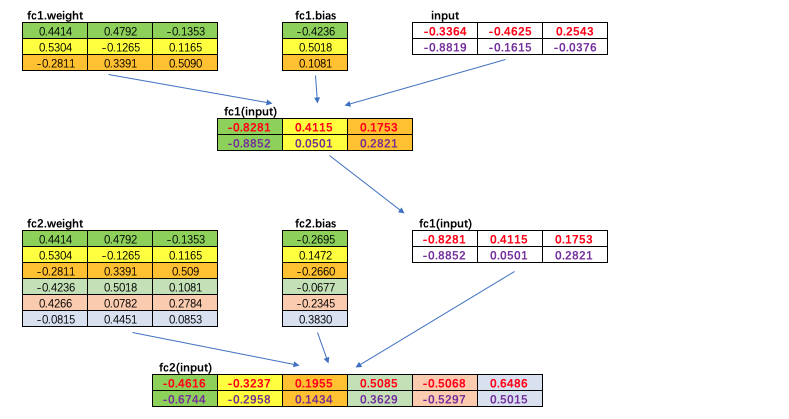